Welcome to one of the collaborative Jupyter/Spark environments in ZHAW. You are not yet connected to Sparky by default. However, the necessary code template makes this a quick process. Keep in mind that you are sharing both the Jupyter environment and the Sparky cluster with others. Custom Python packages on the notebook/Spark driver side are installed with %pip install.

In [1]:
zhawaccount = 'tschadan'# TODO set this to your ZHAW-Kürzel

In [2]:
import sparky
import pyspark
import pandas as pd
#import slash
import pyspark.sql

sc = sparky.connect(f"sparknotebook-{zhawaccount}", 2)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

~~~ Sparky module loaded ~~~


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/29 21:40:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/29 21:40:06 WARN Utils: Service 'sparkDriver' could not bind on port 5555. Attempting port 5556.
24/06/29 21:40:07 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 4444. Attempting port 4445.


Attached to Sparky cluster context from jupyter-secondary as sparknotebook-tschadan.
Requested 2 cores; real number might be less.


### 0. Data Overview

In [20]:
customer_master = pd.read_csv('ExchangeRates.csv')
customer_master[customer_master['ActiveDate'] > 20220101]

,ActiveDate,LocalCurrency,ForeignCurrency,ExchangeRate
30,20220131,CHF,CHF,1.000000
31,20220228,CHF,CHF,1.000000
32,20220331,CHF,CHF,1.000000
33,20220430,CHF,CHF,1.000000
34,20220531,CHF,CHF,1.000000
41,20220331,CHF,CHF,1.000000
74,20220131,CHF,DKK,0.125392
75,20220229,CHF,DKK,0.127904
76,20220331,CHF,DKK,0.130946
77,20220430,CHF,DKK,0.131223


### 1. Install and Import dependencies

In [21]:
# %pip install plotly
%pip install prophet
# %pip install pyarrow

from pyspark.sql.functions import to_date, to_timestamp, col
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import time

### 2. Read in Data and Process Dates

In [22]:
read_time = time.time()
df_currate = spark.read.format("csv").option("header", "true").load("ExchangeRates.csv")
read_time_finish = time.time()
print(f"Time taken to read: {read_time_finish - read_time:.2f} seconds")

df_currate.dtypes

Time taken to read: 0.22 seconds


[('ActiveDate', 'string'),
 ('LocalCurrency', 'string'),
 ('ForeignCurrency', 'string'),
 ('ExchangeRate', 'string')]

In [23]:
df_currate = df_currate.withColumnRenamed('ActiveDate', 'ds') \
                       .withColumnRenamed('ExchangeRate', 'y')

df_currate.filter(col('ds') > '20220101').show(100)
df_currate.printSchema()

+--------+-------------+---------------+--------+
|      ds|LocalCurrency|ForeignCurrency|       y|
+--------+-------------+---------------+--------+
|20220131|          CHF|            CHF|1.000000|
|20220228|          CHF|            CHF|1.000000|
|20220331|          CHF|            CHF|1.000000|
|20220430|          CHF|            CHF|1.000000|
|20220531|          CHF|            CHF|1.000000|
|20220331|          CHF|            CHF|1.000000|
|20220131|          CHF|            DKK|0.125392|
|20220229|          CHF|            DKK|0.127904|
|20220331|          CHF|            DKK|0.130946|
|20220430|          CHF|            DKK|0.131223|
|20220531|          CHF|            DKK|0.131630|
|20220331|          CHF|            DKK|0.130219|
|20220131|          CHF|            EUR|0.934800|
|20220228|          CHF|            EUR|0.953400|
|20220331|          CHF|            EUR|0.976600|
|20220430|          CHF|            EUR|0.978700|
|20220531|          CHF|            EUR|0.981800|


In [24]:
# ActiveDate has to be in DateTime format for prophet to work
df_currate = df_currate.withColumn('ds', to_timestamp(df_currate['ds'], "yyyyMMdd"))

# Filter out rows where 'ds_valid' is null (invalid dates)
df_currate = df_currate.filter(col('ds').isNotNull())

# Cast 'y' to float
#df_currate = df_currate.withColumn('y', df_currate['y'].cast('float'))

df_currate.printSchema()

root
 |-- ds: timestamp (nullable = true)
 |-- LocalCurrency: string (nullable = true)
 |-- ForeignCurrency: string (nullable = true)
 |-- y: string (nullable = true)



### 3. Create Spark DataFrames for currencies

In [25]:
# Filter the DataFrame for usd
df_currate_usd_spark = df_currate.filter(col('ForeignCurrency') == 'USD')

# Check for null values
null_count_usd = df_currate_usd_spark.filter(col('ActiveDate').isNull()).count()
print(f"Number of null values usd: {null_count_usd}")

# Print the DataFrames to verify
df_currate_usd_spark.show(100)

Number of null values usd: 0
+-------------------+-------------+---------------+--------+
|                 ds|LocalCurrency|ForeignCurrency|       y|
+-------------------+-------------+---------------+--------+
|2019-06-30 00:00:00|          CHF|            USD|0.923932|
|2019-07-30 00:00:00|          CHF|            USD|0.905811|
|2019-08-31 00:00:00|          CHF|            USD|0.912540|
|2019-09-30 00:00:00|          CHF|            USD|0.935313|
|2019-10-31 00:00:00|          CHF|            USD|0.911207|
|2019-11-30 00:00:00|          CHF|            USD|0.917891|
|2019-12-31 00:00:00|          CHF|            USD|0.912148|
|2020-01-31 00:00:00|          CHF|            USD|0.932592|
|2020-02-28 00:00:00|          CHF|            USD|0.922940|
|2020-03-31 00:00:00|          CHF|            USD|0.924872|
|2020-04-30 00:00:00|          CHF|            USD|0.970493|
|2020-05-31 00:00:00|          CHF|            USD|0.959675|
|2020-06-30 00:00:00|          CHF|            USD|0.958

In [26]:
# Filter rows where 'ds' is more than 2022-01-01 => FORECAST TEST df
df_currate_usd_spark_test = df_currate_usd_spark.filter(col('ds') > '2022-01-01')
df_currate_usd_spark_test.show()
df_currate_usd_spark_test.printSchema()

# Filter rows where 'ds' is less than 2021-12-31
df_currate_usd_spark_reduced = df_currate_usd_spark.filter(col('ds') < '2022-01-01')

df_currate_usd_spark_reduced.show()
df_currate_usd_spark_reduced.printSchema()

+-------------------+-------------+---------------+--------+
|                 ds|LocalCurrency|ForeignCurrency|       y|
+-------------------+-------------+---------------+--------+
|2022-01-31 00:00:00|          CHF|            USD|0.862600|
|2022-03-31 00:00:00|          CHF|            USD|0.903339|
|2022-04-30 00:00:00|          CHF|            USD|0.913136|
|2022-05-31 00:00:00|          CHF|            USD|0.904718|
|2022-03-31 00:00:00|          CHF|            USD|0.895700|
+-------------------+-------------+---------------+--------+

root
 |-- ds: timestamp (nullable = true)
 |-- LocalCurrency: string (nullable = true)
 |-- ForeignCurrency: string (nullable = true)
 |-- y: string (nullable = true)

+-------------------+-------------+---------------+--------+
|                 ds|LocalCurrency|ForeignCurrency|       y|
+-------------------+-------------+---------------+--------+
|2019-06-30 00:00:00|          CHF|            USD|0.923932|
|2019-07-30 00:00:00|          CHF|   

### 4. Convert to Pandas DataFrames for Prophet

In [27]:
# Convert to Pandas DataFrame
df_currate_usd_pd_reduced = df_currate_usd_spark_reduced.toPandas()

print(f"Number of null values: {df_currate_usd_pd_reduced['ds'].isnull().sum()}")

# Print the DataFrames to verify
df_currate_usd_pd_reduced.head()

Number of null values: 0


/usr/local/lib/python3.11/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,ds,LocalCurrency,ForeignCurrency,y
0,2019-06-30,CHF,USD,0.923932
1,2019-07-30,CHF,USD,0.905811
2,2019-08-31,CHF,USD,0.912540
3,2019-09-30,CHF,USD,0.935313
4,2019-10-31,CHF,USD,0.911207


In [28]:
# Convert the Test DataFrames
df_currate_usd_pd_test = df_currate_usd_spark_test.toPandas()

# Print the Test DataFrames to verify
df_currate_usd_pd_test.head()

/usr/local/lib/python3.11/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,ds,LocalCurrency,ForeignCurrency,y
0,2022-01-31,CHF,USD,0.862600
1,2022-03-31,CHF,USD,0.903339
2,2022-04-30,CHF,USD,0.913136
3,2022-05-31,CHF,USD,0.904718
4,2022-03-31,CHF,USD,0.895700


### 5. Explanation and Execution of Forecasts

**ds (Date Series):**

This column contains the timestamps for the forecasted values. It corresponds to the future dates for which the forecast has been generated.

**yhat (Forecasted Value):**

This column contains the forecasted values of the time series. It is the primary output of the Prophet model and represents the predicted values for the corresponding dates in the ds column.

**yhat_lower (Lower Bound of Forecast):**

This column contains the lower bound of the forecasted values' uncertainty interval. It provides a conservative estimate of the forecast, giving an idea of the potential minimum value the forecast might take.

**yhat_upper (Upper Bound of Forecast):**

This column contains the upper bound of the forecasted values' uncertainty interval. It provides a liberal estimate of the forecast, giving an idea of the potential maximum value the forecast might take.

In [29]:
# Initialize the Prophet model
model = Prophet(interval_width=0.95, daily_seasonality=True)

# Fit the model on the data
model.fit(df_currate_usd_pd_reduced) # change name DataFrame as parameter for other currencies

# Create a DataFrame to hold future dates for forecasting
future = model.make_future_dataframe(periods=6, freq='M')  # Forecasting 6 months into the future from 2022-06-01 on

# Generate the forecast
forecast = model.predict(future)

# Print the forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

21:43:19 - cmdstanpy - INFO - Chain [1] start processing
21:43:19 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
27,2021-07-31,0.871791,0.851820,0.890507
28,2021-08-31,0.880323,0.861170,0.898105
29,2021-09-30,0.918657,0.899027,0.937592
30,2021-10-31,0.909965,0.890285,0.929126
31,2021-11-30,0.856648,0.837052,0.875355
32,2021-12-31,0.840827,0.822641,0.860627
33,2022-01-31,0.817706,0.797641,0.837138
34,2022-02-28,0.817196,0.796607,0.838372
35,2022-03-31,0.878622,0.857719,0.898294
36,2022-04-30,0.762468,0.742863,0.783406


### 5. Plotting Forecast and Real Data

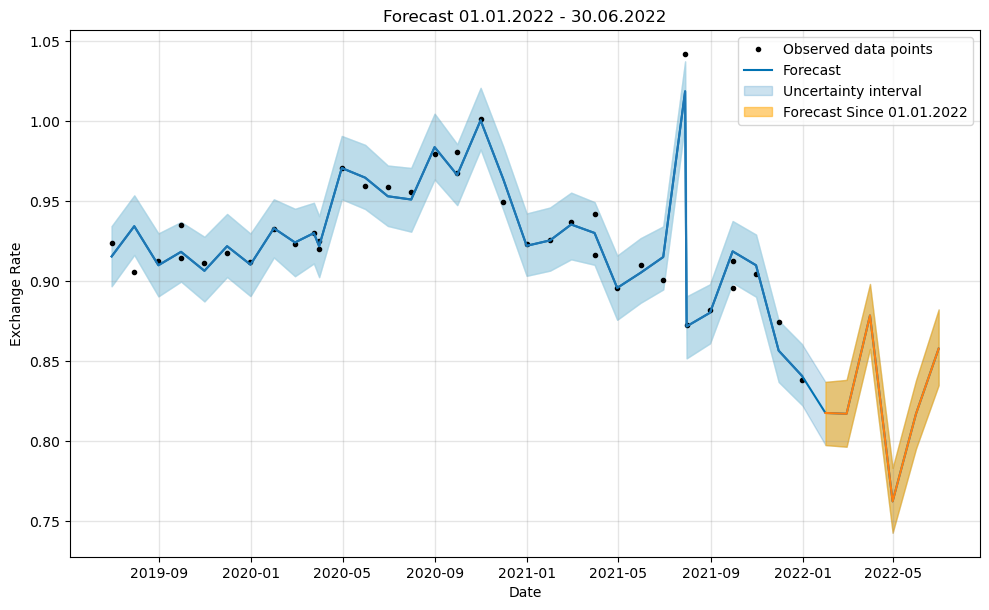

In [30]:
# Split the forecast data based on the specified date
date_split = pd.to_datetime('2022-01-01')
forecast_before = forecast[forecast['ds'] <= date_split]
forecast_after = forecast[forecast['ds'] > date_split]

# Plot the forecast
fig1 = model.plot(forecast)

# Customize the plot
ax = fig1.gca()  # Get the current axes
ax.set_xlabel('Date')
ax.set_ylabel('Exchange Rate')
ax.set_title('Forecast 01.01.2022 - 30.06.2022')

# Plot the forecast lines with different colors
ax.plot(forecast_before['ds'], forecast_before['yhat'])
ax.plot(forecast_after['ds'], forecast_after['yhat'])

# Customize the confidence interval
ax.fill_between(forecast_before['ds'], forecast_before['yhat_lower'], forecast_before['yhat_upper'], color='lightblue', alpha=0.5)
ax.fill_between(forecast_after['ds'], forecast_after['yhat_lower'], forecast_after['yhat_upper'], color='orange', alpha=0.5, label='Forecast Since 01.01.2022')

# Adding the legend again to ensure it captures the custom interval
ax.legend()

# Show the plot
plt.show()

In [31]:
# Prophet model with 0 forecasting months for plotting real Data in forecasting period (01.01.2022-30.06.2022)
model = Prophet(interval_width=0.95, daily_seasonality=True)
model.fit(df_currate_usd_pd_test)
future = model.make_future_dataframe(periods=0, freq='M') 
forecast_test = model.predict(future)

# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing


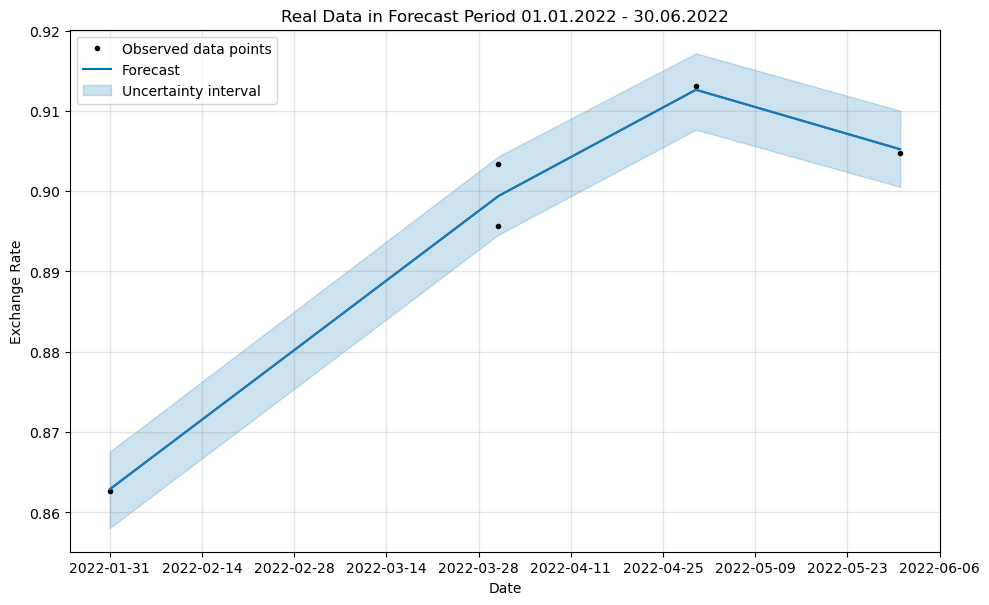

In [32]:
# Plot the real Data (01.01.2022-30.06.2022)
fig2 = model.plot(forecast_test)
ax = fig2.gca()  # Get the current axes
ax.set_xlabel('Date')
ax.set_ylabel('Exchange Rate')
ax.set_title('Real Data in Forecast Period 01.01.2022 - 30.06.2022')
ax.plot(forecast_test['ds'], forecast_test['yhat'])
ax.legend()
plt.show()

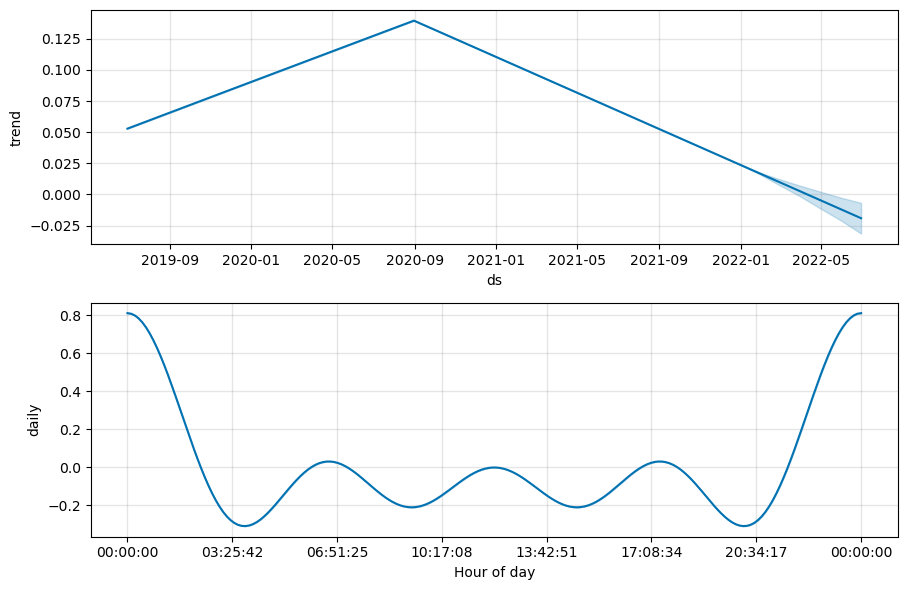

In [33]:
# Plot the forecast components
fig3 = model.plot_components(forecast)
plt.show()

In [ ]:
sc.stop()

Sources:
- https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a
- https://www.kaggle.com/code/kakkarot/starter-hourly-energy-consumption-b71f2600-a
- https://www.youtube.com/watch?v=KvLG1uTC-KU